# IMPORT AND UTILS

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from tensorflow.keras.layers import Dense,Activation,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam,Adagrad,Adamax,RMSprop,SGD,Adadelta
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
model_default_name = 'fantasy_model.h5'
def build_model(inputDim,layers,activation,regularizers,numOfclasses,outputlayerActivation):
  model = Sequential()
  print(inputDim[0],inputDim[1])
  model.add(Dense(layers[0],input_shape=(inputDim[1],)))
  for i in range(1,len(layers)) :
    model.add(Dense(layers[i], activation=activation[i],kernel_regularizer=regularizers[i]))
  model.add(Dense(numOfclasses,activation=outputlayerActivation))
  return model
def save_model(model,name=model_default_name):
  model.save(name) 
def load_model (name = model_default_name):
  model = load_model(name)
def tune_1 (model ,x,y, opts , lrs , losses ,validation_split = 0.2, plot = True , verbose = 0 , batch_size = 50,epochs=50) :
  table = [] # [specs , training data , val data , max differnce to test overfitting]
  for l in losses:
    for o in opts :
      for lr in lrs :
        o.learning_rate.assign(lr)
        model.compile(optimizer= o, loss=l,metrics=['acc'])
        
        hist = model.fit(x=x, y=y, batch_size=batch_size, epochs=epochs, verbose=verbose,  validation_split=validation_split)

        training_acc = hist.history['loss']
        val_acc = hist.history['val_loss']
        specifications ='loss_function : '+str( l)+ ', optimizer :', str(o) +', learning_rate : '+str(lr) 
        best_accuracy_index =np.argmax( np.array(training_acc))
        best_accuracy = training_acc[best_accuracy_index]
        corresponding_validation_acc = val_acc[best_accuracy_index]
        max_difference = best_accuracy - corresponding_validation_acc
        table.append([specifications,training_acc,val_acc ,max_difference])
        if plot :
          print(specifications)
          epoch_count = range(1, len(training_acc) + 1)
          plt.figure()
          plt.plot(epoch_count, training_acc, 'r--')
          plt.plot(epoch_count, val_acc, 'b-')
          plt.legend(['Training Loss', 'Val Loss'])
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.show()
  return table

In [0]:
!git clone https://github.com/vaastav/Fantasy-Premier-League.git

Cloning into 'Fantasy-Premier-League'...
remote: Enumerating objects: 3278, done.
remote: Counting objects: 100% (3278/3278), done.
remote: Compressing objects: 100% (1926/1926), done.
remote: Total 87130 (delta 1090), reused 2606 (delta 991), pack-reused 83852
Receiving objects: 100% (87130/87130), 27.96 MiB | 10.14 MiB/s, done.
Resolving deltas: 100% (39893/39893), done.


In [0]:
cd Fantasy-Premier-League/data/

/content/Fantasy-Premier-League/data


In [0]:
def load_training_set(seasons = ['2016-17'],gws_number=38):
  dfs = [] #data frames of [seosons][gws]
  pos = [] #position of every player
  for season in seasons :
    s =[]
    pos.append(pd.read_csv(season+'/players_raw.csv',encoding = "ISO-8859-1"))
    for i in range(0,gws_number):
     s.append(pd.read_csv(season+'/gws/gw'+str(i+1)+'.csv',encoding = "ISO-8859-1"))
    dfs.append(s)
  return dfs,pos

In [0]:
seasons = ['2016-17','2017-18','2018-19']
training_data,pos = load_training_set(seasons)

# Normalization and To-Categorial

In [0]:
def to_numeric(training_data):
  # >to numeric features (kickoff_time,kickoff_time_formatted,was_home)
  for season in training_data:
    for gw in season:
      gw['was_home'] = gw['was_home'].astype(int)
      for counter in range(0,len(gw)):
        line = gw['kickoff_time'][counter].split('T')
        hour = int(line[1][0:2])
        #print(hour)
        if 0<=hour<=4 or 18<=hour<=23:
          val = 0 # night
        else:
          val =1  # noon
        gw['kickoff_time'][counter] = val
        if 'kickoff_time_formatted' in gw.columns:
          gw['kickoff_time_formatted'][counter] = val
        #    was_home = 1 home
        #    was_home = 0 away

In [0]:
def normalize(training_data):
  #todo normalize data
  train_x=[]
  from sklearn.preprocessing import StandardScaler
  s = StandardScaler()
  for season in training_data:
    tmp=list()
    for gw in season:
      name_ind = [gw.columns.get_loc('name') for c in gw.columns if c in gw][0] 
      element_ind = [gw.columns.get_loc('element') for c in gw.columns if c in gw][0]
      kick_ind=[gw.columns.get_loc('kickoff_time') for c in gw.columns if c in gw][0]
      home_ind = [gw.columns.get_loc('was_home') for c in gw.columns if c in gw][0]
      points_ind = [gw.columns.get_loc('total_points') for c in gw.columns if c in gw][0]
      names = gw['name']
      gw = gw.drop(['name'],axis=1)
      element = gw['element']
      gw = gw.drop(['element'],axis=1)
      home = gw['was_home']
      gw = gw.drop(['was_home'],axis=1)
      kicktime = gw['kickoff_time']
      gw = gw.drop(['kickoff_time'],axis=1)
      points = gw['total_points']
      gw = gw.drop(['total_points'],axis=1)
      normalized = s.fit_transform(gw)
      normalizedData = pd.DataFrame(data = normalized,columns=gw.columns)
      normalizedData.insert(name_ind,"name" ,names,True) #0
      normalizedData.insert(element_ind,"element" ,element,True)#13 
      normalizedData.insert(kick_ind,'kickoff_time' ,kicktime,True)#24 
      normalizedData.insert(home_ind,'was_home' ,home,True)#52
      normalizedData.insert(points_ind,'total_points' ,points,True)
      tmp.append(normalizedData)
    train_x.append(tmp)
  return train_x


In [0]:
to_numeric(training_data)
training_data = normalize(training_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [0]:
#display(training_data[0][0])

# Prepare Input

In [0]:
key = 'name'
#f1_indices = [5,16,20,22]
##            [2,7 ,10,11]
#T1 features : current gameweek status
def add_type1_features(player , curr_index , gws , x,mode='train'): #predicting index+1
  if mode == 'train':
    f1_indices =[5,16,20,22]
  elif mode == 'test':
    f1_indices =[2,7,10,11]
  current_gameweek =gws[curr_index].loc[gws[curr_index][key]==player].values[0]
  for index in f1_indices :
    x.append(current_gameweek[index]) 


#T2 features : statistics on prev gameweeks for that player                       
def add_type2_features(player ,curr_index , gws , x,f2_indices_mean):
  if curr_index > 7 :
    pgws = gws[curr_index-7:curr_index+1]
  else:
    pgws = gws[:curr_index+1]
  prev_gameweeks =[]
  for gw in pgws :
    if len(gw.loc[gw[key]==player].values) == 0 :
      continue
    prev_gameweeks.append(gw.loc[gw[key]==player].values[0])
  for i in f2_indices_mean :
    ls =[row[i] for row in prev_gameweeks]
    if len(ls)!=0:
      mean = np.array(ls).mean()
      x.append(mean)
    else:
      x.append(0)


def add_type2_features_position(pos,player ,curr_index , gws , x,mode='train'):
  if mode == 'train':
      if pos ==1:
      #old f2_mean = [3,7,8,9,10,14,15,17,23,30,35,36,37,39,42,54]#16
        f2_mean = [7,10,18,35,37,39,54]
      elif pos ==2:
        #old f2_mean = [2,3,7,8,9,10,14,15,17,23,30,32,36,37,42,54]#16 I deleted 11(dribble)
        f2_mean = [1,7,10,18,32,37,54]
      elif pos ==3:
        #old f2_mean = [1,3,4,7,9,10,11,14,15,17,18,19,23,37,42,54]#16 I deleted 2(attempted passes)
        f2_mean = [1,7,10,19,37,46,54]
      elif pos ==4:
        #old f2_mean = [1,3,4,9,10,11,18,19,23,29,33,34,37,46,53,54]#16
        f2_mean = [1,10,19,34,37,46,54]
  elif mode == 'test':
      if pos ==1:
        f2_mean = [4,5,8,17,18,20,31]
      elif pos ==2:
        f2_mean = [1,4,5,8,15,18,31]
      elif pos ==3:
        f2_mean = [1,4,5,9,18,24,31]
      elif pos ==4:
        f2_mean = [1,5,9,16,18,24,31]

  add_type2_features(player,curr_index,gws,x,f2_mean)



#f3_indices =[48,49,50,51]
##           [26,27,28,29]


#T3 features : next match satus
def add_type3_features(player ,curr_index , gws , x,mode='train'):
  if mode == 'train':
    f3_indices =[48,49,50,51]
  elif mode == 'test':
    f3_indices =[26,27,28,29]

  if(len(gws) -1 <= curr_index) :
    next_gameweek = gws[curr_index].loc[gws[curr_index][key]==player].values[0]
  else :
    next_gameweek =gws[curr_index].loc[gws[curr_index][key]==player].values[0]
  for i in f3_indices :
    f =next_gameweek[i]
    x.append(f) 

#f4_indices =[52,31,16]
##           [7 ,14,30]

#T4 features : next matches satistics 
def add_type4_features(player ,curr_index , gws , x,mode='train'):
  if mode == 'train':
    f4_indices =[52]#16,31,52
  elif mode == 'test':
    f4_indices = [30]#7,14,30  
  ngw = None
  if(len(gws)-4 > curr_index) :
    ngw = gws[curr_index:curr_index+3]
  else :
    ngw = gws[curr_index:]
  next_gameweeks =[]
  for gw in ngw :
    if len(gw.loc[gw[key]==player].values) == 0 :
      continue
    next_gameweeks.append(gw.loc[gw[key]==player].values[0])
  for i in f4_indices :
    ls =[row[i] for row in next_gameweeks]
    mean = np.array(ls).mean()
    x.append(mean) 

In [0]:
class goalkeeper:
  def __init__(self,train,out,ids=[]):
    self.X = np.array([x for x in train])
    self.Y = np.array(out)
    self.ID = ids
class defender:
  def __init__(self,train,out,ids=[]):
    self.X = np.array([x for x in train])
    self.Y = np.array(out)
    self.ID = ids
class midfielder:
  def __init__(self,train,out,ids=[]):
    self.X = np.array([x for x in train])
    self.Y = np.array(out)
    self.ID = ids
class stricker:
  def __init__(self,train,out,ids=[]):
    self.X = np.array([x for x in train])
    self.Y = np.array(out)
    self.ID = ids
class player:
  def __init__(self,g,d,m,s):
    self.goalkeeper = g
    self.defender = d
    self.midefield = m
    self.stricker = s

In [0]:
import time

data = {"gx":[],"dx":[],"mx":[],"sx":[],"gy":[],"dy":[],"my":[],"sy":[]}
#adding features
maxx = len(training_data)* len(training_data[0])
print('total number of gameweeks :',maxx)

c = 0
c_season = 0
for s in training_data :
  position = pos[c_season]
  c_season+=1
  for i in range(0, len(s)-1):
    print('gameweek:',i+1)
    c+=1
    c2=0
    for p in s[i]['name']:
      Pid = s[i].loc[s[i]['name']==p].values[0][13]
      pos_tmp = position.loc[position['id']==Pid]['element_type'].values[0]
      c2+=1
      x=[]
      y=[]
      add_type1_features(p,i,s,x)
      add_type2_features_position(pos_tmp,p,i,s,x)
      add_type3_features(p,i,s,x)
      add_type4_features(p,i,s,x)
      lim = i+1
      if i+1 >= len(s)-1 :
        lim = len(s)-1
      if len(s[i].loc[s[i]['name']==p].values[0]) > 1:
          if len(s[i+1].loc[s[i+1]['name']==p].values) >0: 
            y=s[i+1].loc[s[i+1]['name']==p].values[0][47]
          else:
            y = 0
          if pos_tmp ==1:
            data['gx'].append(x)
            data['gy'].append(y)
          elif pos_tmp == 2 :
            data['dx'].append(x)
            data['dy'].append(y)
          elif pos_tmp ==3:
            data['mx'].append(x)
            data['my'].append(y)
          elif pos_tmp == 4:
            data['sx'].append(x)
            data['sy'].append(y)
      else:
          print(len(s[i].loc[s[i]['name']==p].values),s[i].loc[s[i]['name']==p].values)


total number of gameweeks : 114
gameweek: 1
gameweek: 2
gameweek: 3
gameweek: 4
gameweek: 5
gameweek: 6
gameweek: 7
gameweek: 8
gameweek: 9
gameweek: 10
gameweek: 11
gameweek: 12
gameweek: 13
gameweek: 14
gameweek: 15
gameweek: 16
gameweek: 17
gameweek: 18
gameweek: 19
gameweek: 20
gameweek: 21
gameweek: 22
gameweek: 23
gameweek: 24
gameweek: 25
gameweek: 26
gameweek: 27
gameweek: 28
gameweek: 29
gameweek: 30
gameweek: 31
gameweek: 32
gameweek: 33
gameweek: 34
gameweek: 35
gameweek: 36
gameweek: 37
gameweek: 1
gameweek: 2
gameweek: 3
gameweek: 4
gameweek: 5
gameweek: 6
gameweek: 7
gameweek: 8
gameweek: 9
gameweek: 10
gameweek: 11
gameweek: 12
gameweek: 13
gameweek: 14
gameweek: 15
gameweek: 16
gameweek: 17
gameweek: 18
gameweek: 19
gameweek: 20
gameweek: 21
gameweek: 22
gameweek: 23
gameweek: 24
gameweek: 25
gameweek: 26
gameweek: 27
gameweek: 28
gameweek: 29
gameweek: 30
gameweek: 31
gameweek: 32
gameweek: 33
gameweek: 34
gameweek: 35
gameweek: 36
gameweek: 37
gameweek: 1
gameweek: 2


In [0]:
g = goalkeeper(data['gx'],data['gy'])
d = defender(data['dx'],data['dy'])
m = midfielder(data['mx'],data['my'])
s = stricker(data['sx'],data['sy'])
print(len(g.X),len(d.X),len(m.X),len(s.X))
wrapper = player(g,d,m,s)

6829 22062 27446 9645


In [0]:
import pickle
with open('Input.data', 'wb') as f:
  pickle.dump(wrapper,f)


# Ready Input (No Need for prepare Input Section)

In [0]:
!git clone https://Ahmed-Nasser@bitbucket.org/Ahmed-Nasser/dl_fantasy_data.git

Cloning into 'dl_fantasy_data'...
remote: Counting objects: 45, done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 45 (delta 11), reused 0 (delta 0)
Unpacking objects: 100% (45/45), done.


In [0]:
import pickle
with open('dl_fantasy_data/Input.data', 'rb') as f:
  wrapper = pickle.load(f)
print(len(wrapper.goalkeeper.X),len(wrapper.defender.X),len(wrapper.midefield.X),len(wrapper.stricker.X))


6829 22062 27446 9645


# MODELS

In [0]:
models=[]#0 for gk,1 for def,2 for mid,3 for st

**GoalKeeper**

[6829, 16]
6829 16
Epoch 1/50
385/385 [==============================] - 1s 3ms/step - loss: 7.7264 - acc: 0.6892 - val_loss: 5.8437 - val_acc: 0.6984
Epoch 2/50
385/385 [==============================] - 1s 3ms/step - loss: 4.6900 - acc: 0.6866 - val_loss: 3.6232 - val_acc: 0.7057
Epoch 3/50
385/385 [==============================] - 1s 3ms/step - loss: 3.0204 - acc: 0.6891 - val_loss: 2.4000 - val_acc: 0.7057
Epoch 4/50
385/385 [==============================] - 1s 3ms/step - loss: 2.1106 - acc: 0.6905 - val_loss: 1.7229 - val_acc: 0.7086
Epoch 5/50
385/385 [==============================] - 1s 3ms/step - loss: 1.6154 - acc: 0.6922 - val_loss: 1.3849 - val_acc: 0.7057
Epoch 6/50
385/385 [==============================] - 1s 3ms/step - loss: 1.3577 - acc: 0.6915 - val_loss: 1.2223 - val_acc: 0.7042
Epoch 7/50
385/385 [==============================] - 1s 3ms/step - loss: 1.2261 - acc: 0.6912 - val_loss: 1.0985 - val_acc: 0.7057
Epoch 8/50
385/385 [==============================] - 1s 

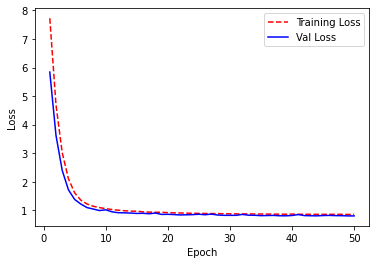

In [0]:
layers = [100]*10
activation = ['relu']*len(layers)
optimizer = [Adam()]
reg = [l2()]*len(layers)
losses = ['mean_absolute_error']
lrs = [1e-4]
input_dim = [len(wrapper.goalkeeper.X),len(wrapper.goalkeeper.X[0])]
print(input_dim)
gmodel = build_model(input_dim,layers,activation,reg,1,'linear')
tune_1(gmodel,wrapper.goalkeeper.X,wrapper.goalkeeper.Y,optimizer,lrs,losses,validation_split = 0.1, plot = True , verbose = 1 , batch_size = 16,epochs=50)
models.append(gmodel)

**Defender**

[22062, 16]
22062 16
Epoch 1/50
621/621 [==============================] - 2s 3ms/step - loss: 4.8049 - acc: 0.6005 - val_loss: 2.9351 - val_acc: 0.6262
Epoch 2/50
621/621 [==============================] - 2s 3ms/step - loss: 2.2716 - acc: 0.6002 - val_loss: 1.5921 - val_acc: 0.6221
Epoch 3/50
621/621 [==============================] - 2s 3ms/step - loss: 1.4938 - acc: 0.5982 - val_loss: 1.1986 - val_acc: 0.6226
Epoch 4/50
621/621 [==============================] - 2s 3ms/step - loss: 1.2706 - acc: 0.5984 - val_loss: 1.0896 - val_acc: 0.6212
Epoch 5/50
621/621 [==============================] - 2s 3ms/step - loss: 1.2027 - acc: 0.5971 - val_loss: 1.0556 - val_acc: 0.6198
Epoch 6/50
621/621 [==============================] - 2s 3ms/step - loss: 1.1758 - acc: 0.5981 - val_loss: 1.0337 - val_acc: 0.6203
Epoch 7/50
621/621 [==============================] - 2s 3ms/step - loss: 1.1629 - acc: 0.5976 - val_loss: 1.0223 - val_acc: 0.6221
Epoch 8/50
621/621 [==============================] - 2

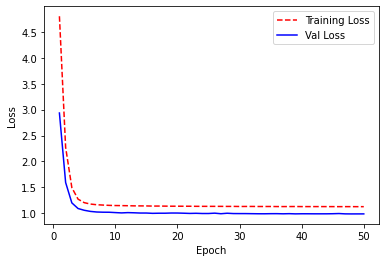

In [0]:
layers = [200]*4
activation = ['relu']*len(layers)
optimizer = [Adam()]
reg = [l2()]*len(layers)
losses = ['mean_absolute_error']
lrs = [1e-4]
input_dim = [len(wrapper.defender.X),len(wrapper.defender.X[0])]
print(input_dim)
dmodel = build_model(input_dim,layers,activation,reg,1,'linear')
tune_1(dmodel,wrapper.defender.X,wrapper.defender.Y,optimizer,lrs,losses,validation_split = 0.1, plot = True , verbose = 1 , batch_size = 32,epochs=50)
models.append(dmodel)

**Midfield**

[27446, 16]
27446 16
Epoch 1/100
772/772 [==============================] - 2s 2ms/step - loss: 3.1431 - acc: 0.5226 - val_loss: 2.3329 - val_acc: 0.5078
Epoch 2/100
772/772 [==============================] - 2s 2ms/step - loss: 1.9560 - acc: 0.5202 - val_loss: 1.6424 - val_acc: 0.5093
Epoch 3/100
772/772 [==============================] - 2s 2ms/step - loss: 1.4854 - acc: 0.5229 - val_loss: 1.3480 - val_acc: 0.5060
Epoch 4/100
772/772 [==============================] - 2s 2ms/step - loss: 1.2882 - acc: 0.5240 - val_loss: 1.2379 - val_acc: 0.5111
Epoch 5/100
772/772 [==============================] - 2s 2ms/step - loss: 1.1952 - acc: 0.5247 - val_loss: 1.1598 - val_acc: 0.5155
Epoch 6/100
772/772 [==============================] - 2s 2ms/step - loss: 1.1443 - acc: 0.5261 - val_loss: 1.1241 - val_acc: 0.5100
Epoch 7/100
772/772 [==============================] - 2s 2ms/step - loss: 1.1120 - acc: 0.5263 - val_loss: 1.1082 - val_acc: 0.5144
Epoch 8/100
772/772 [===========================

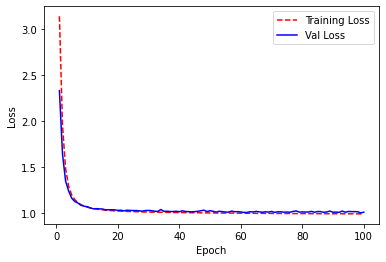

In [0]:
layers = [100]*4#the best for midfield
activation = ['relu']*len(layers)
optimizer = [Adam()]
reg = [l2()]*len(layers)
losses = ['mean_absolute_error']
lrs = [1e-4]
input_dim = [len(wrapper.midefield.X),len(wrapper.midefield.X[0])]
print(input_dim)
mmodel = build_model(input_dim,layers,activation,reg,1,'linear')
tune_1(mmodel,wrapper.midefield.X,wrapper.midefield.Y,optimizer,lrs,losses,validation_split = 0.1, plot = True , verbose = 1 , batch_size = 32,epochs=100)  
models.append(mmodel)

**striker**

[9645, 16]
9645 16
Epoch 1/100
272/272 [==============================] - 1s 2ms/step - loss: 3.8379 - acc: 0.5469 - val_loss: 3.4217 - val_acc: 0.5606
Epoch 2/100
272/272 [==============================] - 1s 2ms/step - loss: 3.1917 - acc: 0.5506 - val_loss: 2.9044 - val_acc: 0.5617
Epoch 3/100
272/272 [==============================] - 1s 2ms/step - loss: 2.7374 - acc: 0.5505 - val_loss: 2.5127 - val_acc: 0.5648
Epoch 4/100
272/272 [==============================] - 1s 2ms/step - loss: 2.3936 - acc: 0.5505 - val_loss: 2.2161 - val_acc: 0.5575
Epoch 5/100
272/272 [==============================] - 1s 2ms/step - loss: 2.1342 - acc: 0.5499 - val_loss: 1.9932 - val_acc: 0.5648
Epoch 6/100
272/272 [==============================] - 1s 2ms/step - loss: 1.9363 - acc: 0.5509 - val_loss: 1.8241 - val_acc: 0.5637
Epoch 7/100
272/272 [==============================] - 1s 2ms/step - loss: 1.7865 - acc: 0.5506 - val_loss: 1.6887 - val_acc: 0.5544
Epoch 8/100
272/272 [=============================

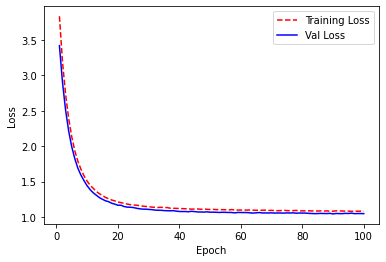

In [0]:
layers = [100]*4
activation = ['relu']*len(layers)
optimizer = [Adam()]
reg = [l2()]*len(layers)
losses = ['mean_absolute_error']
lrs = [1e-4]
input_dim = [len(wrapper.stricker.X),len(wrapper.stricker.X[0])]
print(input_dim)
smodel = build_model(input_dim,layers,activation,reg,1,'linear')
tune_1(smodel,wrapper.stricker.X,wrapper.stricker.Y,optimizer,lrs,losses,validation_split = 0.1, plot = True , verbose = 1 , batch_size = 32,epochs=100)
models.append(smodel)

# Prepare Testing Data

In [0]:
current_season = ['2019-20']
num_of_test_gws = 29
test_data,positions = load_training_set(current_season,num_of_test_gws)

In [0]:
to_numeric(test_data)
test_data = normalize(test_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# gm = [l.get_weights() for l in gmodel.layers]
# with open('GModel.data', 'wb') as m:
#   pickle.dump(gm,m)
# dm = [l.get_weights() for l in dmodel.layers]
# with open('DModel.data', 'wb') as d:
#   pickle.dump(dm,d)
# mm = [l.get_weights() for l in mmodel.layers]
# with open('MModel.data', 'wb') as g:
#   pickle.dump(mm,g)
# sm = [l.get_weights() for l in smodel.layers]
# with open('SModel.data', 'wb') as s:
#   pickle.dump(sm,s)

In [0]:
def compute_step(X,W,b,last):
  Z = np.add(np.dot(W.T,X) , np.array([b] * X.shape[1]).T)
  if last :
    return Z
  else :
    return np.maximum(Z,np.zeros(Z.shape))

def predict(X,layers):
  A = np.copy(X.T)
  for i in range(0,len(layers)):    
    A = compute_step(A,layers[i].get_weights()[0],layers[i].get_weights()[1],i==(len(layers)-1) or i == 0)
  return A

# Evaluating

In [0]:
def add_features_test(gws=[29]):
  data = {"gx":[],"dx":[],"mx":[],"sx":[],"gy":[],"dy":[],"my":[],"sy":[],"gid":[],"did":[],"mid":[],"sid":[]}
  print('total number of gameweeks :',len(gws))
  c_season = 0
  for s in test_data :
    position = positions[c_season]
    c_season+=1
    for i in gws:
      print('gameweek:',i)
      i=i-1
      for p in s[i-1]['name']:
        Pid = s[i-1].loc[s[i-1]['name']==p].values[0][6]
        pos_tmp = position.loc[position['id']==Pid]['element_type'].values[0]
        x=[]
        y=[]
        add_type1_features(p,i-1,s,x,'test')
        add_type2_features_position(pos_tmp,p,i-1,s,x,'test')
        add_type3_features(p,i-1,s,x,'test')
        add_type4_features(p,i-1,s,x,'test')

        if len(s[i].loc[s[i]['name']==p].values) >0: 
          y=s[i].loc[s[i]['name']==p].values[0][25]
        else:
          y = 0
        if pos_tmp ==1:
          data['gx'].append(x)
          data['gy'].append(y)
          data['gid'].append(Pid)
        elif pos_tmp == 2 :
          data['dx'].append(x)
          data['dy'].append(y)
          data['did'].append(Pid)
        elif pos_tmp ==3:
          data['mx'].append(x)
          data['my'].append(y)
          data['mid'].append(Pid)
        elif pos_tmp == 4:
          data['sx'].append(x)
          data['sy'].append(y)
          data['sid'].append(Pid)

  return data

In [0]:
next_game_week_test = 29
test = add_features_test([next_game_week_test])
g = goalkeeper(test['gx'],test['gy'],test['gid'])
d = defender(test['dx'],test['dy'],test['did'])
m = midfielder(test['mx'],test['my'],test['mid'])
s = stricker(test['sx'],test['sy'],test['sid'])
print(len(g.X),len(d.X),len(m.X),len(s.X))
test_dict = player(g,d,m,s)

total number of gameweeks : 1
gameweek: 29
57 165 214 68


In [0]:
# import pickle
# with open('test_dic.data', 'wb') as h:
#   pickle.dump(test,h)

In [0]:
Y_pred =gmodel.predict(test_dict.goalkeeper.X)
indices = sorted( [(x,i) for (i,x) in enumerate([c[0] for c in Y_pred])], reverse=True )[:5]
actual =  sorted( [(x,i) for (i,x) in enumerate([c for c in test_dict.goalkeeper.Y])], reverse=True )[:5]
for i in range(0,len(indices)):
  tmpId = test_dict.goalkeeper.ID[indices[i][1]]
  print(test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==tmpId].values[0][0],"With Actual Points:",test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==tmpId].values[0][25],"with Predicted Points:",indices[i][0])
print("\nThe Actual Data\n")
for i in range(0,len(indices)):
  actId = test_dict.goalkeeper.ID[actual[i][1]]
  print(test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==actId].values[0][0],"With Actual Points:",actual[i][0])

Alisson_Ramses Becker_189 With Actual Points: 0 with Predicted Points: 2.1553814
Nick_Pope_93 With Actual Points: 2 with Predicted Points: 2.1387937
Rui Pedro_dos Santos PatrÃ­cio_411 With Actual Points: 6 with Predicted Points: 2.1151083
Alex_McCarthy_318 With Actual Points: 12 with Predicted Points: 2.1030354
Ben_Foster_366 With Actual Points: 2 with Predicted Points: 2.0927765

The Actual Data

Alex_McCarthy_318 With Actual Points: 12
Vicente_Guaita_131 With Actual Points: 10
David_de Gea_235 With Actual Points: 9
Martin_Dubravka_262 With Actual Points: 8
Mathew_Ryan_47 With Actual Points: 7


In [0]:
Y_pred =dmodel.predict(test_dict.defender.X)
indices = sorted( [(x,i) for (i,x) in enumerate([c[0] for c in Y_pred])], reverse=True )[:5]
actual =  sorted( [(x,i) for (i,x) in enumerate([c for c in test_dict.defender.Y])], reverse=True )[:5]
for i in range(0,len(indices)):
  tmpId = test_dict.defender.ID[indices[i][1]]
  print(test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==tmpId].values[0][0],"With Actual Points:",test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==tmpId].values[0][25],"with Predicted Points:",indices[i][0])
print("\nThe Actual Data\n")
for i in range(0,len(indices)):
  actId = test_dict.defender.ID[actual[i][1]]
  print(test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==actId].values[0][0],"With Actual Points:",actual[i][0])

Harry_Maguire_160 With Actual Points: 5 with Predicted Points: 6.683214
James_Tarkowski_84 With Actual Points: 1 with Predicted Points: 6.4844127
Javier_Manquillo_256 With Actual Points: 5 with Predicted Points: 5.4405003
MartÃ­n_Montoya_38 With Actual Points: 5 with Predicted Points: 5.0823336
Jack_Stephens_308 With Actual Points: 2 with Predicted Points: 4.259102

The Actual Data

Victor_LindelÃ¶f_225 With Actual Points: 9
Scott_Dann_127 With Actual Points: 8
Romain_SaÃ¯ss_407 With Actual Points: 8
Willy_Boly_405 With Actual Points: 8
Aaron_Wan-Bissaka_122 With Actual Points: 7


In [0]:
Y_pred =mmodel.predict(test_dict.midefield.X)
indices = sorted( [(x,i) for (i,x) in enumerate([c[0] for c in Y_pred])], reverse=True )[:5]
actual =  sorted( [(x,i) for (i,x) in enumerate([c for c in test_dict.midefield.Y])], reverse=True )[:5]
for i in range(0,len(indices)):
  tmpId = test_dict.midefield.ID[indices[i][1]]
  print(test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==tmpId].values[0][0],"With Actual Points:",test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==tmpId].values[0][25],"with Predicted Points:",indices[i][0])
print("\nThe Actual Data\n")
for i in range(0,len(indices)):
  actId = test_dict.midefield.ID[actual[i][1]]
  print(test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==actId].values[0][0],"With Actual Points:",actual[i][0])

Giovani_Lo Celso_523 With Actual Points: 0 with Predicted Points: 7.5912504
Dennis_Praet_517 With Actual Points: 2 with Predicted Points: 7.1463575
Frederico_Rodrigues de Paula Santos_244 With Actual Points: 2 with Predicted Points: 6.939159
Wilfried_Zaha_133 With Actual Points: 2 with Predicted Points: 4.9450855
Ashley_Westwood_101 With Actual Points: 1 with Predicted Points: 3.908645

The Actual Data

Harvey_Barnes_172 With Actual Points: 19
Willian_Borges Da Silva_113 With Actual Points: 13
Sadio_ManÃ©_192 With Actual Points: 13
Pedro_RodrÃ­guez Ledesma_114 With Actual Points: 12
Ross_Barkley_117 With Actual Points: 12


In [0]:
Y_pred =smodel.predict(test_dict.stricker.X)
indices = sorted( [(x,i) for (i,x) in enumerate([c[0] for c in Y_pred])], reverse=True )[:5]
actual =  sorted( [(x,i) for (i,x) in enumerate([c for c in test_dict.stricker.Y])], reverse=True )[:5]
for i in range(0,len(indices)):
  tmpId = test_dict.stricker.ID[indices[i][1]]
  print(test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==tmpId].values[0][0],"With Actual Points:",test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==tmpId].values[0][25],"with Predicted Points:",indices[i][0])
print("\nThe Actual Data\n")
for i in range(0,len(indices)):
  actId = test_dict.stricker.ID[actual[i][1]]
  print(test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==actId].values[0][0],"With Actual Points:",actual[i][0])

Callum_Wilson_67 With Actual Points: 5 with Predicted Points: 6.4770455
Christian_Benteke_129 With Actual Points: 1 with Predicted Points: 5.7321324
Joelinton CÃ¡ssio_ApolinÃ¡rio de Lira_466 With Actual Points: 0 with Predicted Points: 3.1414714
Dwight_Gayle_554 With Actual Points: 2 with Predicted Points: 3.0779872
Troy_Deeney_362 With Actual Points: 2 with Predicted Points: 2.2273693

The Actual Data

Jamie_Vardy_166 With Actual Points: 11
Chris_Wood_91 With Actual Points: 9
Olivier_Giroud_110 With Actual Points: 6
Jordan_Ayew_468 With Actual Points: 6
Jay_Rodriguez_451 With Actual Points: 5


# Deployment

In [0]:
import requests
team_id = 531277
try:
    entry_season_request = requests.get(f'https://fantasy.premierleague.com/api/entry/{team_id}/event/{next_game_week_test-1}/picks/')
    entry_season_data = entry_season_request.json()
    entry_season_data['entry'] = team_id
    entry_season_data['event'] = next_game_week_test-1
except Exception as e:
  print("Error in request")
team = entry_season_data['picks']

In [0]:
def get_player_type(pid):
  return positions[0].loc[positions[0]['id']==pid]['element_type'].values[0]
def compare(Y_pred,points,val,ids):
  ind = -1
  for i in range(0,len(Y_pred)):
    pid = ids[i]
    new_val = test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==pid].values[0][29]
    if (Y_pred[i][0]>points and new_val<=val):
      points = Y_pred[i][0]
      ind = i
  return ind

def get_best_transfer(position,pid):
  old_name = test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==pid].values[0][0]
  old_val =  test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==pid].values[0][29]
  if position ==1:
    if(pid not in test_dict.goalkeeper.ID):
       return
    ind = test_dict.goalkeeper.ID.index(pid)
    Y_pred =gmodel.predict(test_dict.goalkeeper.X)
    old_points = Y_pred[ind][0]
    new_ind = compare(Y_pred,old_points,old_val,test_dict.goalkeeper.ID)
    new_id = test_dict.goalkeeper.ID[new_ind]
    new_points = Y_pred[new_ind]
    new_name = test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==new_id].values[0][0]
    #new_val =  test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==new_id].values[0][29]
  elif position == 2 :
    if(pid not in test_dict.defender.ID):
       return
    ind = test_dict.defender.ID.index(pid)
    Y_pred =dmodel.predict(test_dict.defender.X)
    old_points = Y_pred[ind][0]
    new_ind = compare(Y_pred,old_points,old_val,test_dict.defender.ID)
    new_id = test_dict.defender.ID[new_ind]
    new_points = Y_pred[new_ind]
    new_name = test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==new_id].values[0][0]
    #new_val =  test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==new_id].values[0][29]
  elif position ==3:
    if(pid not in test_dict.midefield.ID):
      return
    ind = test_dict.midefield.ID.index(pid)
    Y_pred =mmodel.predict(test_dict.midefield.X)
    old_points = Y_pred[ind][0]
    new_ind = compare(Y_pred,old_points,old_val,test_dict.midefield.ID)
    new_id = test_dict.midefield.ID[new_ind]
    new_points = Y_pred[new_ind]
    new_name = test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==new_id].values[0][0]
    #new_val =  test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==new_id].values[0][29]
  elif position == 4:
    if(pid not in test_dict.stricker.ID):
      return
    ind = test_dict.stricker.ID.index(pid)
    Y_pred =smodel.predict(test_dict.stricker.X)
    old_points = Y_pred[ind][0]
    new_ind = compare(Y_pred,old_points,old_val,test_dict.stricker.ID)
    new_id = test_dict.stricker.ID[new_ind]
    new_points = Y_pred[new_ind]
    new_name = test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==new_id].values[0][0]
    #new_val =  test_data[0][next_game_week_test-1].loc[test_data[0][next_game_week_test-1]['element']==new_id].values[0][29]
  #print("Replace:","(",old_name,",",old_points,",",old_val,")"," >> ","(",new_name,",",new_points,",",new_val,")")
  print(old_name,old_points," >> ",new_name ,new_points)




In [0]:
for player in team:
  p_type = get_player_type(player['element'])
  get_best_transfer(p_type,player['element'])


NameError: ignored